In [1]:
__author__ = 'Giada Pastorelli <gpastorelli.astro@gmail.com>' # single string; emails in <>
__version__ = '20221121' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['lsst_sim']  # datasets used in this notebook; 
__keywords__ = ['tutorial', 'Milky Way', 'catalogues', 'plot:histogram', 'plot:cmd', 'plot:color-color'], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/astro-datalab/notebooks-latest/blob/master/internal/keywords.txt

# Combining single and binary models: the South Galactic Pole

*Giada Pastorelli*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [SQL query](#chapter1)
* [Getting useful data and plotting functions](#chapter2)
* [Number counts, CMDs and CCDs](#chapter3)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
Combine the single and binary catalogs from `lsst_sim.simdr2` and `lsst_sim.simdr2_binary` datasets to provide a more realistic description of a real stellar population.

# Summary
As we have two separate catalogs for single and binary stars, these catalogs should be combined together to provide a realistic description of real stellar populations. The present computation of binary systems represents just one-tenth of the binaries that should be in a “binaries-only” simulation. 
We show how to combine the two catalogs and we plot the resulting and luminosity functions, CMDs and color-color diagrams.
In this example we use stars in the South Galactic Pole.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

* LSST White paper: Dal Tio et al., 2022, "Simulating the Legacy Survey of Space and Time Stellar Content with TRILEGAL", ApJS, 262, 22. https://doi.org/10.3847/1538-4365/ac7be6

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
from getpass import getpass

# 3rd party # remove imports that are not needed
import numpy as np
import pylab as plt
import matplotlib.colors as colors
from astroML.stats import binned_statistic_2d
import statistics
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
# Data Lab helpers as needed, e.g.: (uncomment as needed)
#from dl.helpers.utils import convert

# user-defined 
from utils import plot_2D_hess


<a class="anchor" id="auth"></a>
# Authentication
This notebook does not require authentication. However, if you wish to make use of virtual storage and myDB you have to log in to the server with your credentials.



In [3]:
# With the following you can check if you are authenticated or an anonymous user
ac.whoAmI()

'anonymous'

If you want to authenticate you can uncomment the following lines to get a token that will be stored on the server

In [4]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))

In [5]:
# Uncomment the following to check if your token is valid

#if not ac.isValidToken(token):
#    raise Exception('Token is not valid. Please check your usename/password and execute this cell again.')

<a class="anchor" id="chapter1"></a>
# SQL query

Here we define a couple of functions to perform the query needed to retrieve the simulated sources in the South Galactic Pole (SGP).
The first one will get single stars in the SGP, i.e. sources with b <= -85 degrees, from the single-star catalog `lsst_sim.simdr2`. 
The second one will get binary systems in the SGP from the binary-star catalog `lsst_sim.simdr2_binary`.

**Warning:** Due a mismatch between the ages of tracks on the RGB and the zero-age
horizontal branch, for a minor fraction of binary stars there is an excess of HB stars in old metal poor populations. These stars can be identified with the following: 

```
c1_mass > 0.7 && c1_mass < 0.9 && logage > 10.0 && c1_label == 4 && c1_logg > 3.2
```

The above condition is included in the function ```get_sgp_query_binary()``` to retrieve binary stars from the simulated catalogs.

In [6]:
# Query to retrieve single stars in the SGP
# and select all sources with b <= -85
def get_sgp_query_single():
    query=\
    """SELECT umag, gmag, rmag
       FROM lsst_sim.simdr2
       WHERE galb <= -85"""

    return query 

In [7]:
# This defines the query to retrieve binary stars in the SGP
# and select all sources with b <= -85
def get_sgp_query_binary():
    query=\
    """SELECT c3_umag, c3_gmag, c3_rmag 
       FROM lsst_sim.simdr2_binary
       WHERE galb <= -85 
             AND NOT (c1_mass > 0.7 AND c1_mass < 0.9 AND logage > 10.0 AND c1_label = 4 AND c1_logg > 3.2)
    """
    
    return query    

We execute both queries and print the them

In [8]:
# Single stars query
sgp_single = get_sgp_query_single()
print (sgp_single)

SELECT umag, gmag, rmag
       FROM lsst_sim.simdr2
       WHERE galb <= -85


In [9]:
# Binary stars query
sgp_binary = get_sgp_query_binary()
print (sgp_binary)

SELECT c3_umag, c3_gmag, c3_rmag 
       FROM lsst_sim.simdr2_binary
       WHERE galb <= -85 
             AND NOT (c1_mass > 0.7 AND c1_mass < 0.9 AND logage > 10.0 AND c1_label = 4 AND c1_logg > 3.2)
    


With our selected queries, we now retrieve the data and print the number of objects and the first lines of the tables

In [10]:
%%time
cat_single = qc.query(sql=sgp_single,fmt='pandas') # cat_single is a pandas DataFrame
print("Number of objects:", cat_single.shape[0])
print(cat_single.head())

Number of objects: 1567784
     umag    gmag    rmag
0  28.045  26.450  25.768
1  30.893  28.471  27.245
2  28.400  25.772  24.460
3  30.797  27.107  25.444
4  18.700  17.715  17.252
CPU times: user 430 ms, sys: 375 ms, total: 805 ms
Wall time: 23.2 s


In [11]:
%%time
cat_binary = qc.query(sql=sgp_binary,fmt='pandas') # cat_binary is a pandas DataFrame
print("Number of objects:", cat_binary.shape[0])
print(cat_binary.head())

Number of objects: 126897
   c3_umag  c3_gmag  c3_rmag
0   31.538   28.611   27.112
1   27.939   26.793   26.031
2   22.420   19.483   18.148
3   29.798   27.289   26.013
4   29.515   26.561   25.142
CPU times: user 68.7 ms, sys: 14.5 ms, total: 83.2 ms
Wall time: 4.84 s


<a class="anchor" id="chapter2"></a>
# Combining the two catalogs

The scheme for simulating binaries introduced in [Dal Tio et al. (2021)](https://doi.org/10.3847/1538-4365/ac7be6) produces both non-interacting and
interacting binaries, with a more realistic distribution of mass ratios (and also orbital parameters), and in numbers deﬁned by
the population initial total mass. To reproduce a given stellar density using single and binary models, this scheme requires
the speciﬁcation of a suitable initial binary fraction (by mass), `fbin`.

We recommend a `fbin=0.4`, as being both most robust (see Dal Tio et al. 2021) and more consistent with the way the stellar densities were originally calibrated in TRILEGAL. As we simulated only one-tenth of expected binaries, the `fbin` value of 0.4 can be
achieved by randomly selecting 60 per cent of single stars and by multiplying by 4 the number of binary systems present in
the same region.

In [12]:
# Get 60 percent of single stars
cat_single60 = cat_single.sample(frac=0.6, random_state=7) # fixed random state to reproduce the example

In [13]:
# Get useful magnitude data

# Magnitudes of single stars

umag = cat_single['umag']
rmag = cat_single['rmag']
gmag = cat_single['gmag']

# Single stars 60 per cent - Magnitudes
umag60 = cat_single60['umag']
rmag60 = cat_single60['rmag']
gmag60 = cat_single60['gmag']

# Magnitude of the total binary system
umag3 = cat_binary['c3_umag']
rmag3 = cat_binary['c3_rmag']
gmag3 = cat_binary['c3_gmag']


In [14]:
# Calculates the mode of specific parameters
# such as the Galactic Component associated to a simulated star 
# If the sample of a bin is multimodal, it returns the first found mode value
def multimode_gc (x):
    mm = statistics.multimode(x)
    return mm[0]

<a class="anchor" id="chapter4"></a>
# Luminosity functions for single and binary stars

First we plot the luminosity functions in the r-band for single and binary stars separately

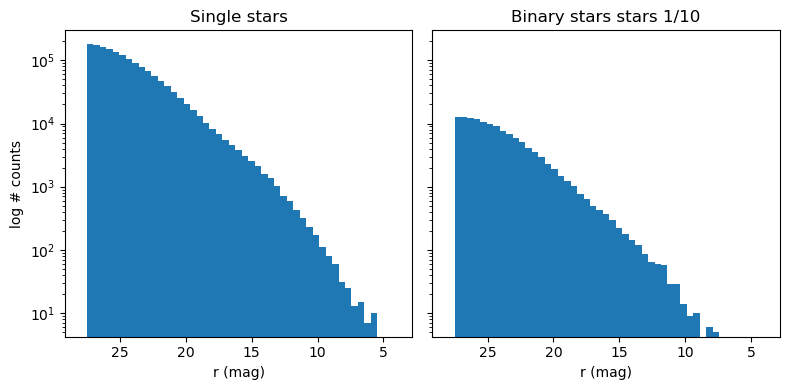

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (8,4))

bins = np.linspace(4,28,50)

# 1. r-mag single stars
ax1.hist(rmag, bins=bins)
ax1.set_xlabel("r (mag)")
ax1.invert_xaxis()
ax1.set_title("Single stars")
ax1.set_ylabel("log # counts")

# 2. r-mag binary systems
ax2.hist(rmag3, bins=bins)
ax2.set_xlabel("r (mag)")
ax2.invert_xaxis()
ax2.set_title("Binary stars stars 1/10")

ax1.set_yscale("log")

# Use tight_layout
plt.tight_layout()


Now, we combine the two catalogs to obtain the r-band luminosity function of a population of stars with `fbin` = 0.4

In [16]:
# Histogram of single stars
count_single60, bin_single = np.histogram(rmag60, bins = bins)

In [17]:
# Histogram of binary stars
count_bin, bin_bin = np.histogram(rmag3, bins = bins)

In [18]:
#Get the bin centers
bin_centers = 0.5*( bin_single[1:] + bin_single[:-1])

In [19]:
# Combined histogram
count_comb = count_single60+4.*count_bin

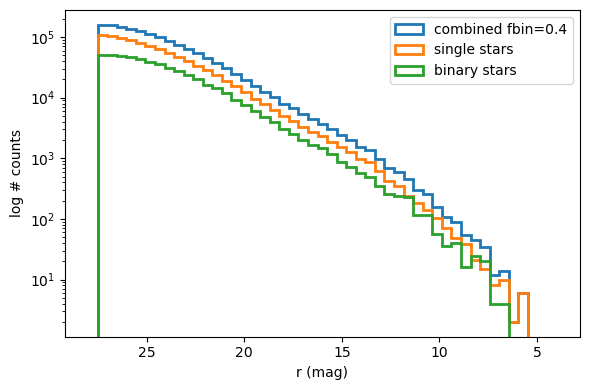

In [20]:
fig, ax1 = plt.subplots(1,1, figsize = (6,4))

ax1.hist(bin_centers, bins = bin_single, weights = count_comb, histtype ='step', lw=2, label = 'combined fbin=0.4')

ax1.hist(bin_centers, bins = bin_single, weights = count_single60, histtype ='step', lw=2, label = 'single stars')
ax1.hist(bin_centers, bins = bin_single, weights = 4*count_bin, histtype ='step', lw=2, label = 'binary stars')


ax1.legend()
ax1.set_yscale("log")
# Axis labels
ax1.set_xlabel('r (mag)')
ax1.set_ylabel("log # counts")
ax1.invert_xaxis()
# Use tight_layout
plt.tight_layout()

# CMDs and CCDs

In the following, we use the function `binned_statistic_2d()` to get the Hess diagrams. 

In [21]:
# Define the number of bins in color and magnitude
bins = [np.arange(-1,3,0.05), np.arange(4,28,0.1)]

# Hess diagrams of the stellar density for single stars.
H1, xed1, yed1 = binned_statistic_2d(gmag60-rmag60, rmag60, None, statistic='count', bins=bins)
#get_2Dhess_param(gmag60-rmag60, rmag60, None, stat='count', bins=bins)

# Hess diagrams of the stellar density for binary stars.
H2, xed2, yed2 = binned_statistic_2d(gmag3-rmag3, rmag3, None, statistic='count', bins=bins)

# Let's multiply the number counts of the binary Hess diagram by 4 to get 
# the expected number of binary stars for a fbin = 0.4 

H2*=4.

# Combination of the single and binary hess diagrams
H12 = H1 + H2

Now we plot the Hess diagrams color-coded according to the stellar density.

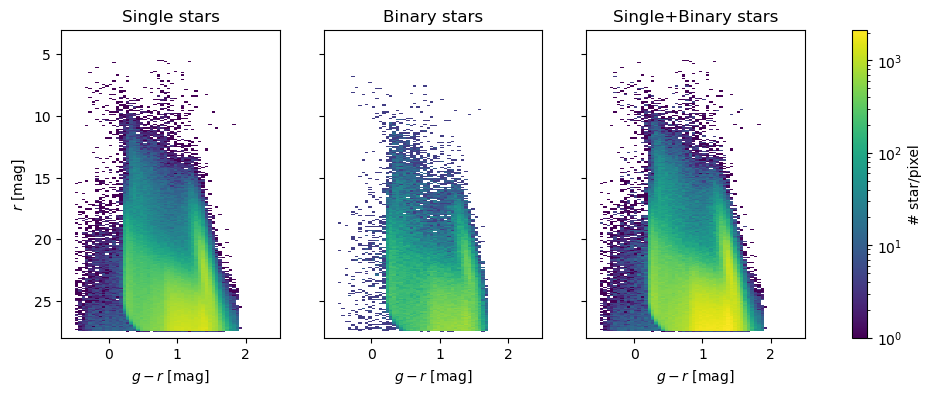

In [22]:
fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, sharex=True, sharey=True, figsize = (12,4))

# Normalization
norm = colors.LogNorm(1, np.max(H12))

#Single stars
plot_2D_hess(H1, xed1, yed1, ax = ax1, norm=norm)

#Binary stars
plot_2D_hess(H2, xed2, yed2, ax = ax2, norm=norm)

#Combined single and binary stars
cc = plot_2D_hess(H12, xed2, yed2, ax = ax3, norm=norm)

#Make a single colorbar
axes = fig.get_axes()
fig.colorbar(cc, ax = axes, label="# star/pixel")

# Limits
ax1.set_ylim(28, 3)
ax1.set_xlim(-0.7, 2.5)

# Axis labels
for ax in [ax1]:
    ax.set_ylabel("$r$ [mag]")
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel("$g - r$ [mag]")

# Axis titles
ax1.set_title("Single stars")
ax2.set_title("Binary stars")
ax3.set_title("Single+Binary stars");

We use the function `binned_statistic_2d` to get the Hess diagrams for the color-color plots 

In [23]:
# Define bins in color-color
bins_cc = [ np.arange(-1,4.5,0.025), np.arange(-1,3,0.025)]

# Color-color Hess diagram of the stellar density for single stars.
H1cc, xed1cc, yed1cc = binned_statistic_2d(umag60 - gmag60, gmag60-rmag60, None, statistic='count', bins=bins_cc)

# Color-color Hess diagram of the stellar density for binary stars.
H2cc, xed2cc, yed2cc = binned_statistic_2d(umag3-gmag3, gmag3-rmag3, None, statistic='count', bins=bins_cc)

# Let's multiply the number counts of the binary Hess diagram by 4 to get 
# the expected number of binary stars for a fbin = 0.4 

H2cc*=4

# Combination of the single and binary hess diagrams
H12cc = H1cc + H2cc

Plots of the color-color Hess diagrams

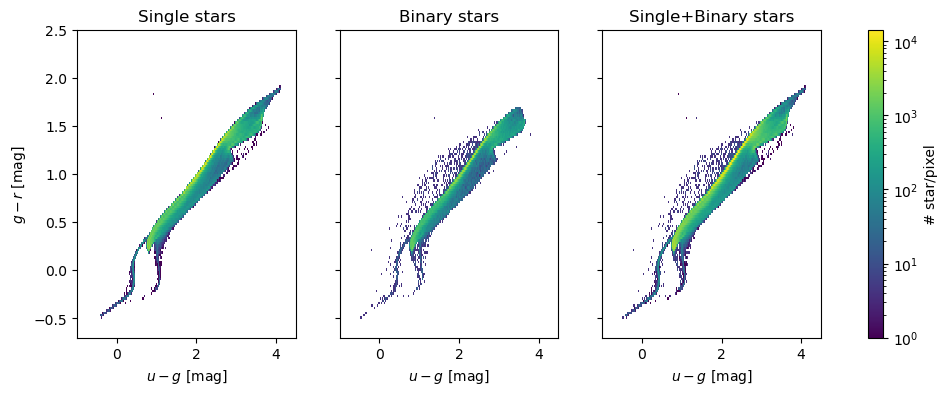

In [24]:
fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, sharex=True, sharey=True, figsize = (12,4))

norm = colors.LogNorm(1, np.max(H12cc))

plot_2D_hess(H1cc, xed1cc, yed1cc, ax = ax1, norm=norm)

plot_2D_hess(H2cc, xed2cc, yed2cc, ax = ax2, norm=norm)

cc = plot_2D_hess(H12cc, xed1cc, yed1cc, ax = ax3, norm=norm)

#Make a single colorbar
axes = fig.get_axes()
fig.colorbar(cc, ax = axes, label="# star/pixel")

ax1.set_xlim(-1, 4.5)
ax1.set_ylim(-0.7, 2.5)

# Axis labels
for ax in [ax1]:
    ax.set_ylabel("$g - r$ [mag]")
for ax in [ax1,ax2, ax3]:
    ax.set_xlabel("$u - g$ [mag]")

# Set a title for the entire figure
ax1.set_title("Single stars")
ax2.set_title("Binary stars")
ax3.set_title("Single+Binary stars");

<a class="anchor" id="resources"></a>
# Resources and references

astroML examples: https://www.astroml.org/examples/datasets/plot_SDSS_SSPP.html

LSST White paper: Dal Tio et al., 2022, "Simulating the Legacy Survey of Space and Time Stellar Content with TRILEGAL", ApJS, 262, 22. https://doi.org/10.3847/1538-4365/ac7be6